# Generative Adversarial Network State Tomography Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import qsttoolkit as qst

## Data Preparation

We start by defining the dimensionality of our system as `dim`, and the phase space grid for our measurement data - Husimi Q function representations of the states in phase space. This grid is defined to be `data_dim` x `data_dim`:

In [ ]:
dim = 32
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

We first create test state density matrices of seven different varieties using the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework. The first three states can be produced directly using QuTiP functions, the other four are specific superpositions of Fock and coherent states and are produced using custom functions in `qsttoolkit.data`:

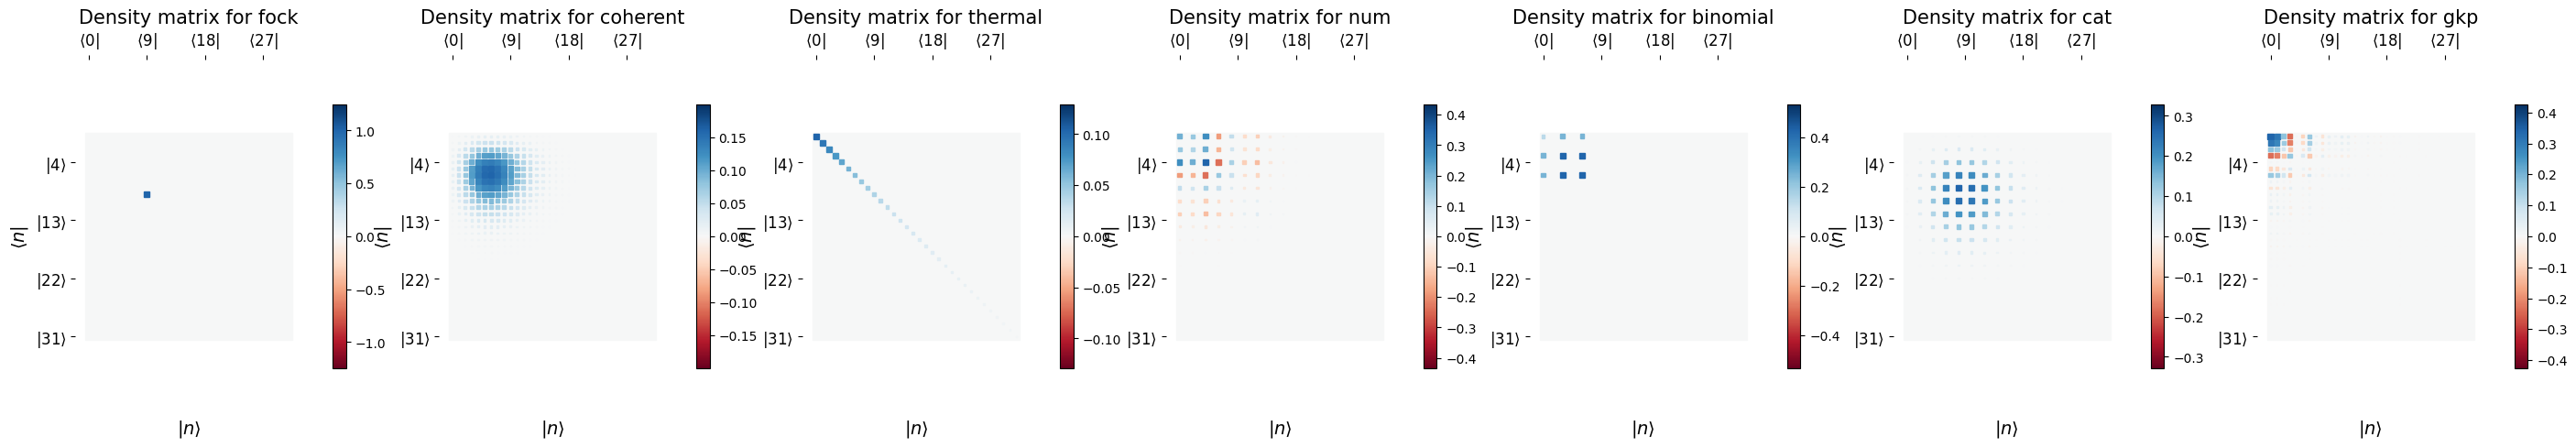

In [ ]:
fock_test = qt.fock_dm(dim, 9)
coherent_test = qt.coherent_dm(dim, 2.5)
thermal_test = qt.thermal_dm(dim, 9)
num_test = qst.data.num_dm('M2', dim)
binomial_test = qst.data.binomial_dm(dim, 2, 2, 1)
cat_test = qst.data.cat_dm(dim, 3)
gkp_test = qst.data.gkp_dm(dim, [-5, 5], [-5, 5], 0.5, 4.5)

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
qst.plot_Hinton(fock_test, ax=ax[0], label='fock')
qst.plot_Hinton(coherent_test, ax=ax[1], label='coherent')
qst.plot_Hinton(thermal_test, ax=ax[2], label='thermal')
qst.plot_Hinton(num_test, ax=ax[3], label='num')
qst.plot_Hinton(binomial_test, ax=ax[4], label='binomial')
qst.plot_Hinton(cat_test, ax=ax[5], label='cat')
qst.plot_Hinton(gkp_test, ax=ax[6], label='gkp')
plt.show()

We create the measurement operators for displace-and-measure phase space Husimi Q measurements of quantum states using `qsttoolkit.tomography.measurement_operators()`:

In [ ]:
measurement_operators = qst.tomography.measurement_operators(dim, 'Husimi_Q', xgrid=xgrid, pgrid=pgrid)

We choose our test_state and apply mixed state noise, and then create, format and reshape the Husimi Q measurement data. Redefine `test_state` below with the different states created above:

In [ ]:
test_state = qst.mixed_state_noise(num_test, 0.2).full()
expectation_values = qst.expectation(test_state, measurement_operators)
measurement_data = expectation_values.numpy().reshape(1, data_dim**2)           # Reshape the expectation values to a 1D array

## Modelling

We create an instance of the `qsttoolkit.tomography.GANQuantumStateTomography` class, which handles the model architecture, compiling and training:

In [ ]:
GAN_reconstructor = qst.tomography.GANQuantumStateTomography(data_dim=data_dim**2)

Training the generator adversarially to learn to reconstruct the test density matrix from measurements using the `.reconstruct` method:

In [ ]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)     # Suppress TensorFlow warnings that can occur in some environments

GAN_reconstructor.reconstruct(measurement_data,
                              measurement_operators,
                              epochs=1000,
                              verbose_interval=100,
                              num_progress_saves=10,        # Save the progress of the training
                              true_dm=test_state)           # For calculating the fidelity of the reconstructed during training

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['data_vector_input']
Received: inputs=Tensor(shape=(1, 1024))
  warnings.warn(msg)


Epoch 0/1000, Generator Loss: 0.6893534064292908, Discriminator Loss: 0.687846302986145, Fidelity: 0.20157855139165
Epoch 100/1000, Generator Loss: 0.8721686005592346, Discriminator Loss: 0.4712263345718384, Fidelity: 0.20459086912786464
Epoch 200/1000, Generator Loss: 0.740831196308136, Discriminator Loss: 0.5189700722694397, Fidelity: 0.24414194124304966
Epoch 300/1000, Generator Loss: 0.7483733892440796, Discriminator Loss: 0.603219747543335, Fidelity: 0.7059036715452225
Epoch 400/1000, Generator Loss: 0.496618390083313, Discriminator Loss: 0.8788825869560242, Fidelity: 0.6269477024715876
Epoch 500/1000, Generator Loss: 0.6120565533638, Discriminator Loss: 0.7921884059906006, Fidelity: 0.7908719685720145
Epoch 600/1000, Generator Loss: 0.6831179857254028, Discriminator Loss: 0.7048991918563843, Fidelity: 0.8125550977174171
Epoch 700/1000, Generator Loss: 0.7139977812767029, Discriminator Loss: 0.674291729927063, Fidelity: 0.7994881983510126
Epoch 800/1000, Generator Loss: 0.65982180

## Analysis

Model statistics over training progress:

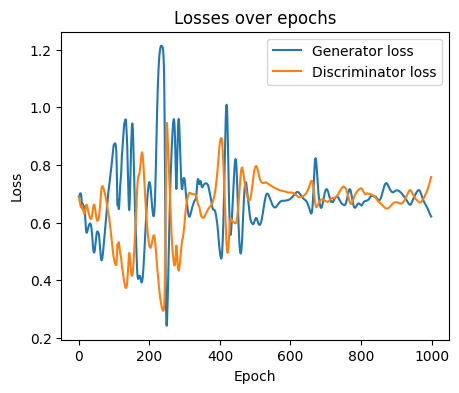

In [ ]:
GAN_reconstructor.plot_losses()

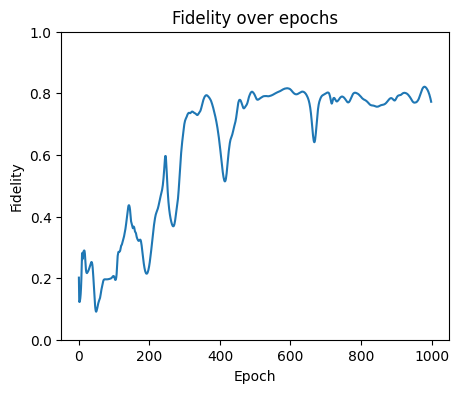

In [ ]:
GAN_reconstructor.plot_fidelities()

Comparison of the true and reconstructed states:

In [ ]:
print(f"State fidelity: {qst.fidelity(test_state, GAN_reconstructor.reconstructed_dm)}")

State fidelity: 0.7668696935227647


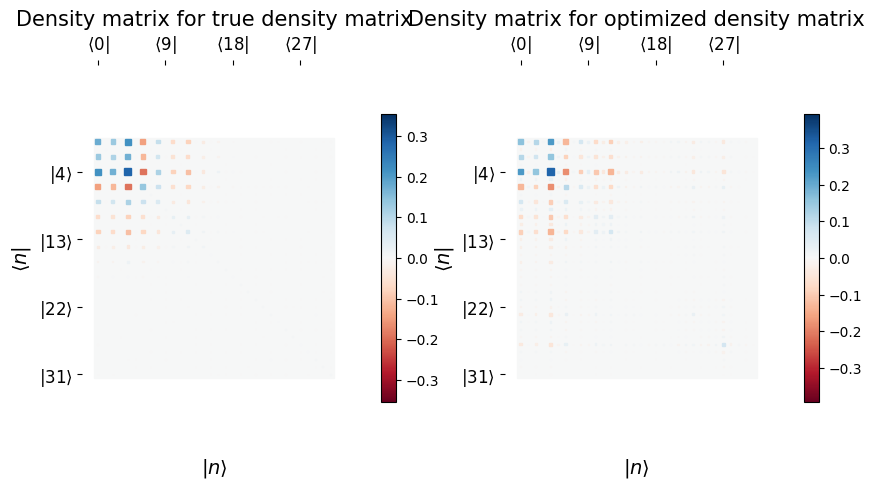

In [ ]:
GAN_reconstructor.plot_comparison_Hintons(test_state)

Comparison of the original test data, and data sampled from the reconstructed state:

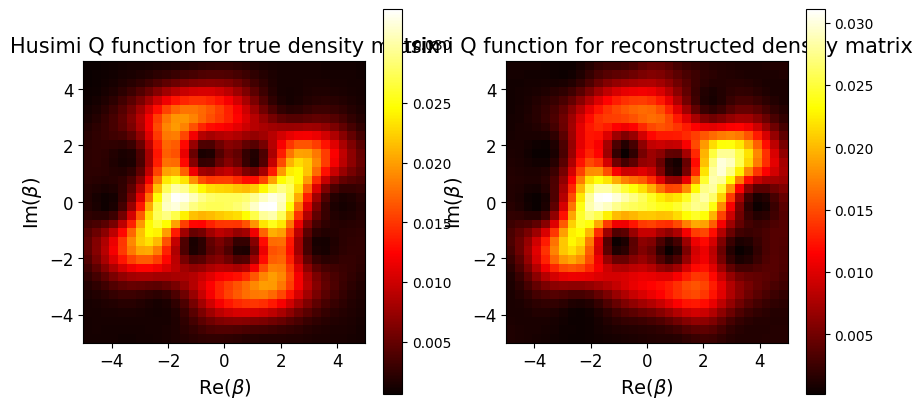

In [ ]:
GAN_reconstructor.plot_comparison_Husimi_Qs(test_state, xgrid, pgrid)

Inspection of reconstructions from intermediate parametrizations during optimisation:

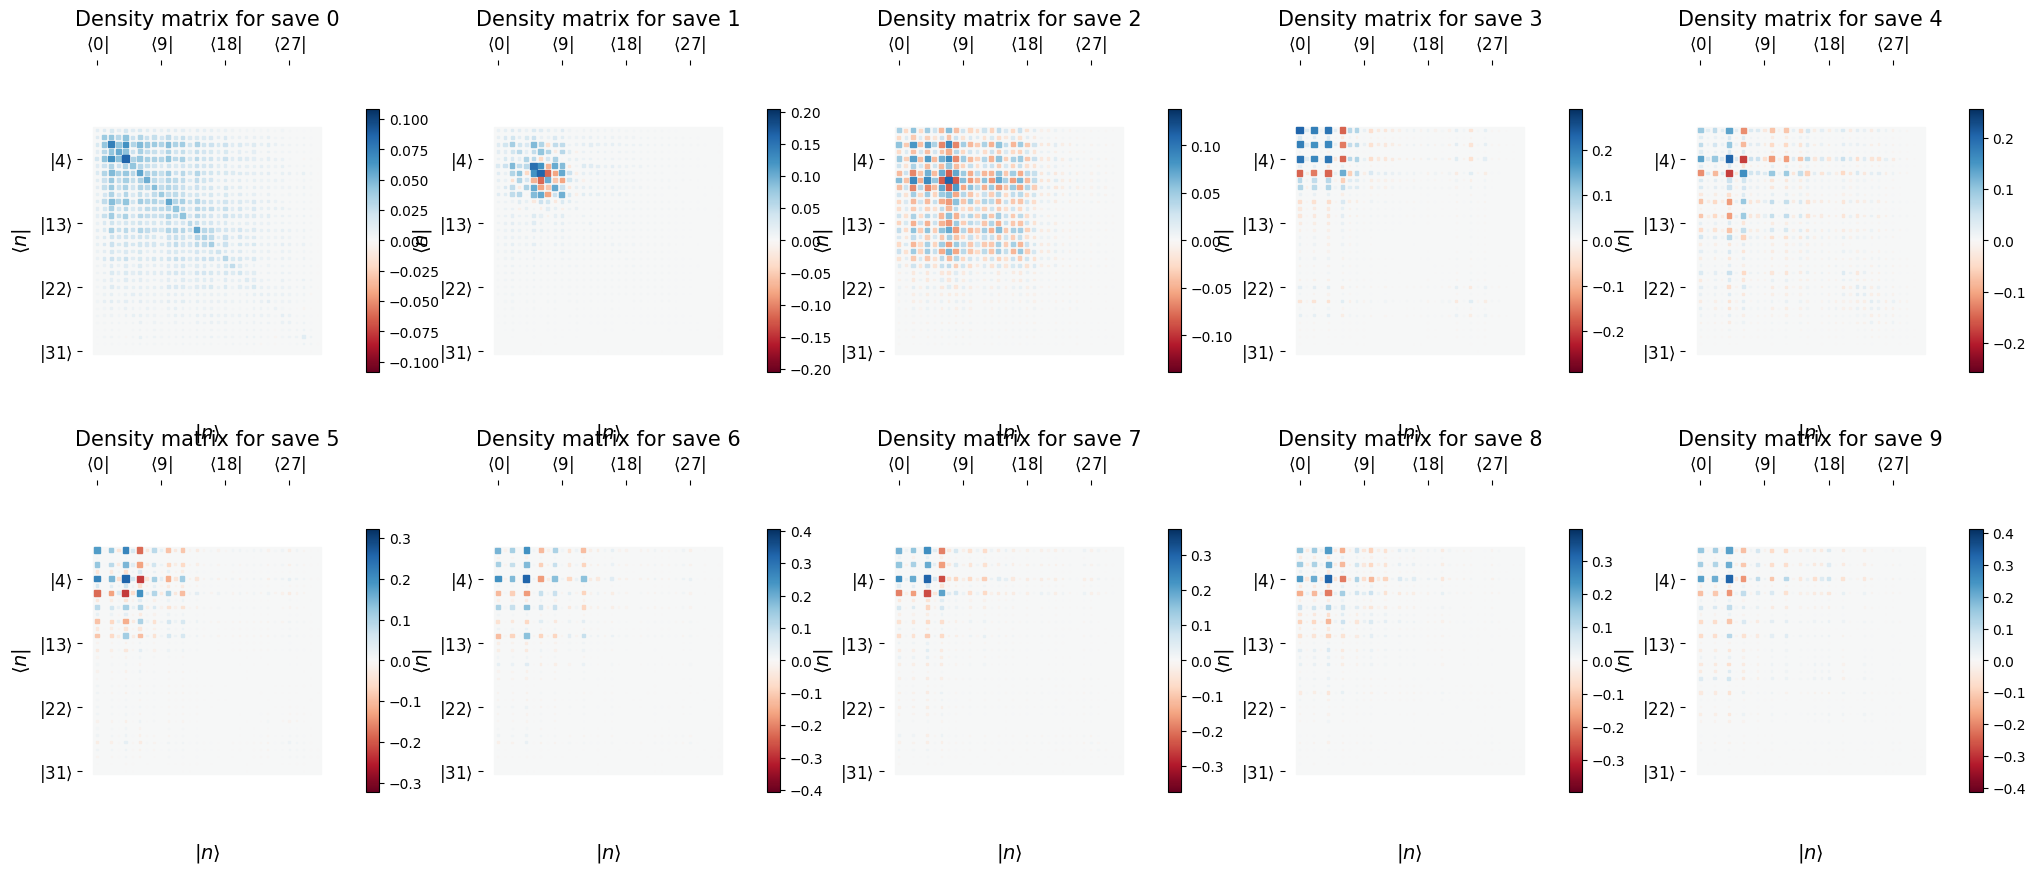

In [ ]:
GAN_reconstructor.plot_intermediate_Hintons()

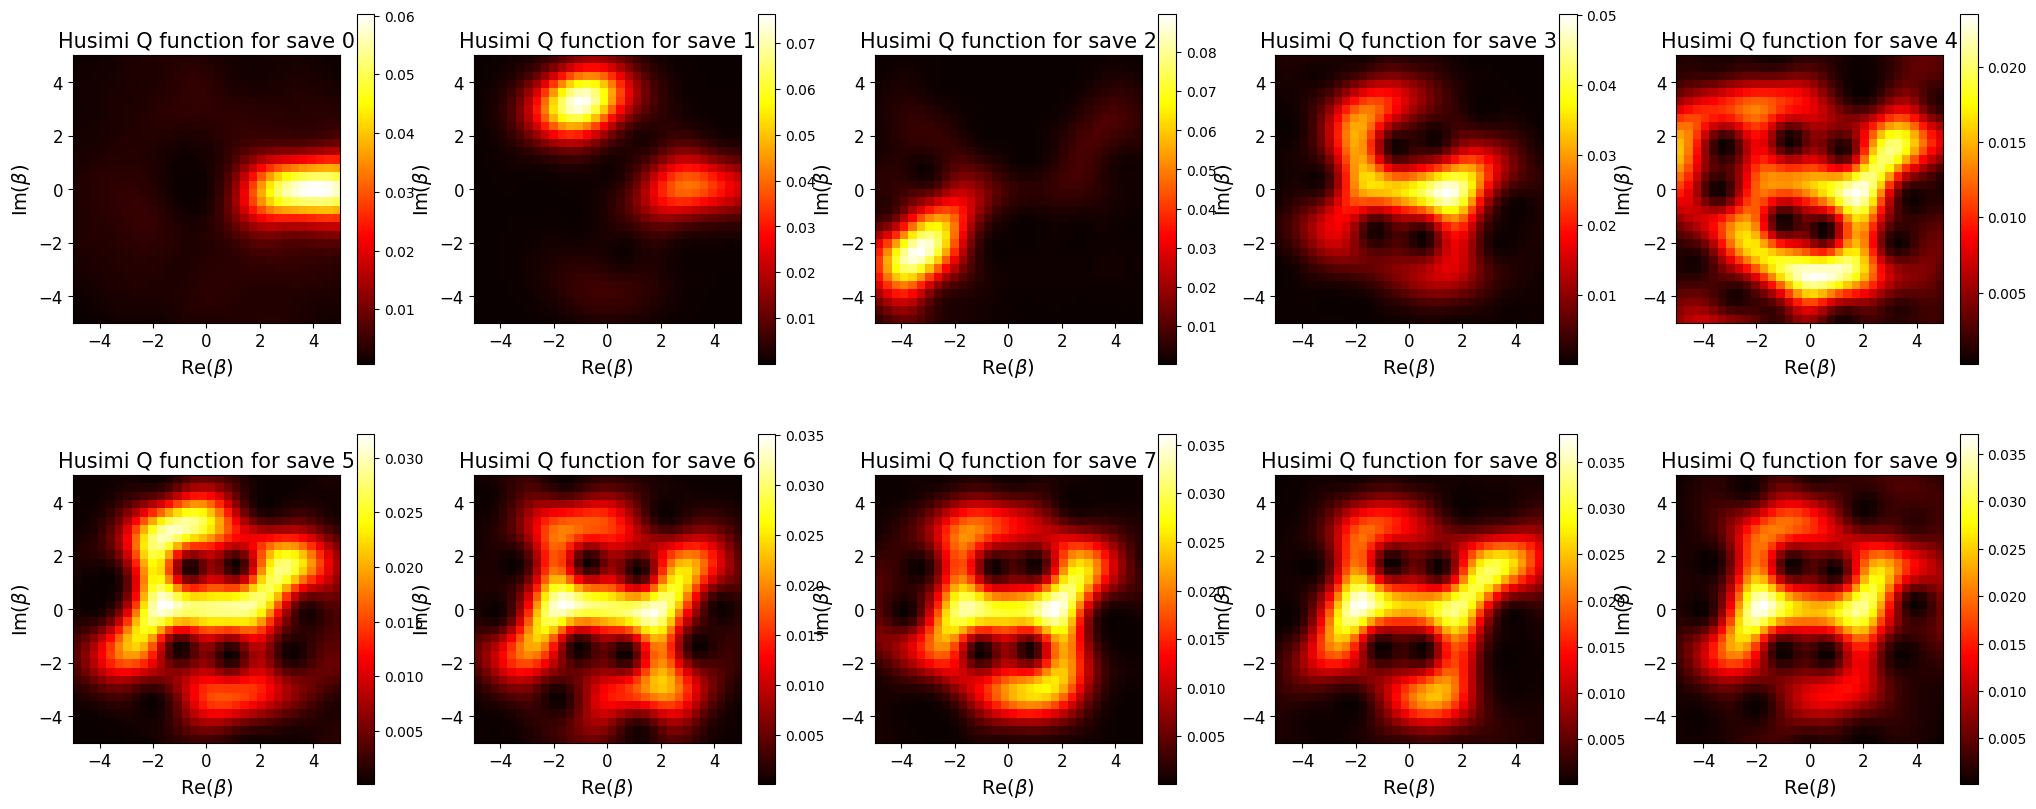

In [ ]:
GAN_reconstructor.plot_intermediate_Husimi_Qs(xgrid, pgrid)

GANs train to find a balance between the performance of the generator and discriminator models. The plot below displays the fidelity between the true and reconstructed states for each point in the generator/discriminator loss space over the training:

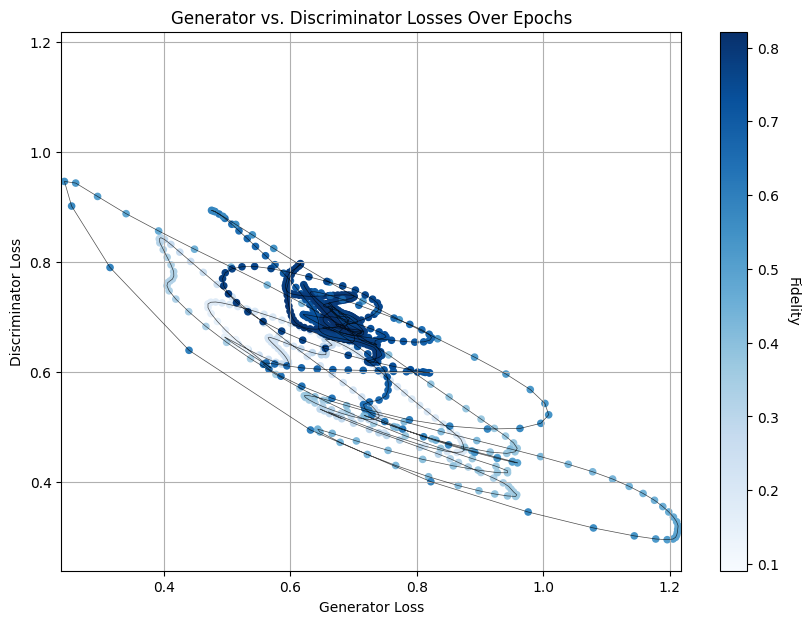

In [ ]:
GAN_reconstructor.plot_loss_space()

`GANQuantumStateTomography.generator` and `GANQuantumStateTomography.discriminator` can be treated as `tensorflow.keras.Model` objects, for example:

In [ ]:
GAN_reconstructor.generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_vector_input (InputLayer)       │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 2)           │           1,026 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cholesky_lower_triangular            │ (None, 32, 32, 2)           │               0 │
│ (CholeskyLowerTriangular)            │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 626,850 (2.39 MB)

 Trainable params: 626,594 (2.39 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
GAN_reconstructor.discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_vector_input (InputLayer)       │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,569 (553.00 KB)

 Trainable params: 141,569 (553.00 KB)

 Non-trainable params: 0 (0.00 B)